In [12]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 37.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 111.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 134.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 144.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#!pip uninstall lambeq --quiet --yes
!pip install lambeq
#feb 27th 2024- Getting error in RemoveCups. Which I can't figure out. Some domain codomain thing.
#tried passing train_diags_raw as it is..clearly failed saying >> operation cannot work on circuits

In [7]:
EPOCHS=10


In [8]:
#!lambeq --version

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Fri Jun 21 22:34:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:A1:00.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

ModuleNotFoundError: No module named 'tensorflow'

In [11]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Your runtime has 540.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [13]:
from lambeq.text2diagram.tree_reader import BobcatParser
import lambeq

parser= BobcatParser()


Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...


In [14]:
import fasttext as ft
embedding_model = ft.load_model('cc.en.300.bin')


In [15]:
MAXPARAMS = 108

In [16]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

eval_metrics = {"acc": acc}

#the initial phases of the gates
def generate_initial_parameterisation(train_circuits, test_circuits, embedding_model, qnlp_model):

     # extract the words from the circuits
    # Note that in this vocab, the same word can have multiple types, which each occur separately
    train_vocab = {symb.name.rsplit('_', 1)[0] for d in train_circuits for symb in d.free_symbols}
    test_vocab = {symb.name.rsplit('_', 1)[0] for d in test_circuits for symb in d.free_symbols}
    
    print(len(test_vocab.union(train_vocab)), len(train_vocab), len(test_vocab))
    print(f'OOV word count: {len(test_vocab - train_vocab)} / {len(test_vocab)}')

    #the words i think depccg couldnt parse
    n_oov_symbs = len({symb.name for d in test_circuits for symb in d.free_symbols} - {symb.name for d in train_circuits for symb in d.free_symbols})
    print(f'OOV symbol count: {n_oov_symbs} / {len({symb.name for d in test_circuits for symb in d.free_symbols})}')

    max_word_param_length = max(max(int(symb.name.rsplit('_', 1)[1]) for d in train_circuits for symb in d.free_symbols),
                            max(int(symb.name.rsplit('_', 1)[1]) for d in test_circuits for symb in d.free_symbols)) + 1
    print(f'Max params/word: {max_word_param_length}')

    #for each word in train and test vocab get its embedding from fasttext
    #todo@jan7th2023: get the embedding from gpt
    train_vocab_embeddings = {wrd: embedding_model[wrd.split('__')[0]] for wrd in train_vocab}
    test_vocab_embeddings = {wrd: embedding_model[wrd.split('__')[0]] for wrd in test_vocab}


    #to store all the initial weights
    initial_param_vector = []

    for sym in qnlp_model.symbols:
        wrd, idx = sym.name.rsplit('_', 1)
        initial_param_vector.append(train_vocab_embeddings[wrd][int(idx)])

    qnlp_model.weights = np.array(initial_param_vector)

    return train_vocab_embeddings, test_vocab_embeddings, max_word_param_length



def generate_OOV_parameterising_model(trained_qnlp_model, train_vocab_embeddings, max_word_param_length):
    """Read arguments from command line.

    Args:
    trained_qnlp_model- the trained_qnlp_model
    train_vocab_embeddings- the initial embeddings for words in the vocab got from fasttext
    max_word_param_length- what is the maximum size of a word

    Returns:
    Weights of a NN model which now understands/has weights for each word in fasttext as its original embedding influenced/mapped to the weights in the trained QNLP model

    """

    #dictionary that map words in the trained QNLP model to its weights at the end of QNLP training
    trained_params_raw = {symbol: param for symbol, param in zip(trained_qnlp_model.symbols, trained_qnlp_model.weights)}


    # train_vocab_embeddings are the initial embeddings for words in the vocab got from fasttext- for each such word create an array of zeroes
    trained_param_vectors = {wrd: np.zeros(max_word_param_length) for wrd in train_vocab_embeddings}


    #for each such symbol and parameter weight assign the weights to the empty array created above.-
    for symbol, train_val in trained_params_raw.items():
        wrd, idx = symbol.name.rsplit('_', 1)
        trained_param_vectors[wrd][int(idx)] = train_val

    wrds_in_order = list(train_vocab_embeddings.keys())

    #so the value to be trained now are the initial weights of each word from 
    #fasttext, which will be trained against  gold label -trained_param_vectors i.e weights from the trained QNLP model
    NN_train_X = np.array([train_vocab_embeddings[wrd] for wrd in wrds_in_order])
    NN_train_Y = np.array([trained_param_vectors[wrd] for wrd in wrds_in_order])


    OOV_NN_model = keras.Sequential([
      layers.Dense(int((max_word_param_length + MAXPARAMS) / 2), activation='tanh'),
      layers.Dense(max_word_param_length, activation='tanh'),
    ])

    OOV_NN_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(0.001))

    # Embedding dim!
    OOV_NN_model.build(input_shape=(None, MAXPARAMS))

    hist = OOV_NN_model.fit(NN_train_X, NN_train_Y, validation_split=0.2, verbose=0, epochs=120)

    print(f'OOV NN model final epoch loss: {(hist.history["loss"][-1], hist.history["val_loss"][-1])}')

    # plt.plot(hist.history['loss'], label='loss')
    # plt.plot(hist.history['val_loss'], label='val_loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Error')
    # plt.legend()
    # plt.show()

    return OOV_NN_model


def evaluate_test_set(pred_model, test_circuits, test_labels, trained_params, test_vocab_embeddings, max_word_param_length, OOV_strategy='random', OOV_model=None):

    pred_parameter_map = {}
    # Use the words from train wherever possible, else use DNN prediction
    for wrd, embedding in test_vocab_embeddings.items():
        if OOV_strategy == 'model':
            pred_parameter_map[wrd] = trained_params.get(wrd, OOV_model.predict(np.array([embedding]), verbose=0)[0])
        elif OOV_strategy == 'embed':
            pred_parameter_map[wrd] = trained_params.get(wrd, embedding)
        elif OOV_strategy == 'zeros':
            pred_parameter_map[wrd] = trained_params.get(wrd, np.zeros(max_word_param_length))
        else:
            pred_parameter_map[wrd] = trained_params.get(wrd, 2 * np.random.rand(max_word_param_length)-1)

    pred_weight_vector = []

    for sym in pred_model.symbols:
        wrd, idx = sym.name.rsplit('_', 1)
        pred_weight_vector.append(pred_parameter_map[wrd][int(idx)])

    pred_model.weights = pred_weight_vector

    preds = pred_model.get_diagram_output(test_circuits)
    if OOV_strategy == 'model':
        wandb.log({"sent1_class1_weight": preds[0][0]})
        wandb.log({"sent1_class2_weight": preds[0][1]})
        wandb.log({"sent2_class1_weight": preds[1][0]})
        wandb.log({"sent2_class2_weight": preds[1][1]})


    return loss(preds, test_labels), acc(preds, test_labels)


def trained_params_from_model(trained_qnlp_model, train_embeddings, max_word_param_length):

    """Read arguments from command line.

     Args:
    trained_qnlp_model- the trained_qnlp_model
    train_vocab_embeddings- the initial embeddings for words in the vocab got from fasttext
    max_word_param_length- what is the maximum size of a wor

    Returns:
        a map between each word and its latest final weights
    """

    trained_param_map = { symbol: param for symbol, param in zip(trained_qnlp_model.symbols, trained_qnlp_model.weights)}
    trained_parameterisation_map = {wrd: np.zeros(max_word_param_length) for wrd in train_embeddings}

    for symbol, train_val in trained_param_map.items():
        wrd, idx = symbol.name.rsplit('_', 1)
        trained_parameterisation_map[wrd][int(idx)] = train_val
    return trained_parameterisation_map

def parsePerSentence(data1,data2):
    diags1 = []
    diags2 = []
    for sentence1,sentence2 in zip(data1,data2):
        try:
            diag1 = parser.sentence2diagram(sentence1)
            diag2 = parser.sentence2diagram(sentence2)
        except :
            print(f"sentence {sentence1} or {sentence2} had a parsing error. skipping it")
            continue
        diags1.append(diag1)
        diags2.append(diag2)
    return diags1,diags2

2024-06-21 22:45:43.669613: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:45:43.672740: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:45:43.708294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 22:45:44.690923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
path_base = "/data-store/iplant/home/mithunpaul08/qnlp/data/mnli/"
train_file = "train_small.txt"
dev_file = "dev_small.txt"

In [26]:
import string
import os



train_X_1 = []
train_X_2 = []
train_y = []




with open(os.path.join(path_base,train_file), encoding='utf-8-sig') as f:
    for line in f:        
        procd_line = line.strip().split('\t')
        train_X_1.append(procd_line[3])
        train_X_2.append(procd_line[4])
        train_y.append(int(procd_line[0]))




test_X_1 = []
test_X_2 = []
test_y = []


with open(os.path.join(path_base,dev_file), encoding='utf-8-sig') as f:
    for line in f:
        procd_line = line.strip().split('\t')
        test_X_1.append(procd_line[3])
        test_X_2.append(procd_line[4])
        test_y.append(int(procd_line[0]))



MAXLEN = 20

filt_train_X1 = []
filt_train_X2 = []
filt_train_y = []

filt_test_X1 = []
filt_test_X2 = []
filt_test_y = []

ctr_train = 0
#add them all into one line
for label, s1, s2 in zip(train_y, train_X_1, train_X_2):
    if max((len(s1.split(' ')), len(s2.split(' ')))) <= MAXLEN:
        ctr_train += 1
        val=s1.translate(str.maketrans('', '', string.punctuation))
        filt_train_X1.append(val)
        filt_train_X2.append(s2.translate(str.maketrans('', '', string.punctuation)))
        this_y = [0, 0]
        this_y[label] = 1
        filt_train_y.append(this_y)

print("***here2")        
print(len(filt_train_X1))
print(len(filt_train_X2))
print(len(filt_train_y))


ctr_test = 0
for label, s1, s2 in zip(test_y, test_X_1, test_X_2):
    if max((len(s1.split(' ')), len(s2.split(' ')))) <= MAXLEN:
        ctr_test += 1
        filt_test_X1.append(s1.translate(str.maketrans('', '', string.punctuation)))
        filt_test_X2.append(s2.translate(str.maketrans('', '', string.punctuation)))
        this_y = [0, 0]
        this_y[label] = 1
        filt_test_y.append(this_y)

print("***here3")        
print(len(filt_test_X1))
print(len(filt_test_X2))
print(len(filt_test_y))

print(filt_train_X1[0])


***here2
64
64
64
***here3
10
10
10
One of our number will carry out your instructions minutely


In [27]:
for index,f in enumerate(filt_train_X1):
    if index==7:
        print(f)

train_diags1 = parser.sentences2diagrams(filt_train_X1,suppress_exceptions=True)
train_diags2 = parser.sentences2diagrams(filt_train_X2,suppress_exceptions=True)

test_diags1 = parser.sentences2diagrams(filt_test_X1,suppress_exceptions=True )
test_diags2 = parser.sentences2diagrams(filt_test_X2,suppress_exceptions=True )

print(len(train_diags1))
print(len(train_diags2))
print(len(test_diags1))
print(len(test_diags2))


Issues in Data Synthesis


Tagging sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/64 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/64 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/64 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/64 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/3 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/10 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/3 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/10 [00:00<?, ?it/s]

64
64
10
10


In [28]:
# We omit any case where the 2 phrases are not parsed to the same type- refer page 44 in Khatri thesis
from collections import Counter
assert len(train_diags1) == len(train_diags2)
assert len(test_diags1) == len(test_diags2)


# print((train_diags1[0].dom))
# print((train_diags1[0].cod))
# print((train_diags1[1].dom))
# print((train_diags1[1].cod))

# these lines are expanded into function below and added try catch
#from collections import Counter
# joint_diagrams_train = [d1 @ d2.transpose() if d1.cod == d2.cod else None for (d1, d2) in zip(train_diags1, train_diags2)]
# joint_diagrams_test = [d1 @ d2.transpose() if d1.cod == d2.cod else None for (d1, d2) in zip(test_diags1, test_diags2)]

# #note in the original work of nikhil tree_reader_dev_khetri_thesis.ipynb- this is d2.r. I cant remember if 
#conjuagate() was the latest or .r()- 
# # i think this was a fix that got pushe dinto discopy circa april 2023- 
#for which I met Khatri and he fixed this.
# #update .r is old and .conjugate is new released in v 0.3.3
# joint_diagrams_train = [d1 @ d2.conjugate if d1.cod == d2.cod else None for (d1, d2) in zip(train_diags1, train_diags2)]
# joint_diagrams_test = [d1 @ d2.conjugate if d1.cod == d2.cod else None for (d1, d2) in zip(test_diags1, test_diags2)]



#moved to a separate function so as to add try catch
import sys
def checkParsedSameType(diags1,diags2):
    ret = []
    counter =0
    for index,(d1, d2) in enumerate(zip(diags1, diags2)):
        try:

            if(d1) and (d2):
                if d1.cod == d2.cod:
                    ret.append(d1 @ d2.transpose())
                else:
                    counter+=1
                    print("codomains dont match")
                    print("****")
            else:
                print(f" d1 or d2 is none")
                if not(d1):
                    print(f"d1 is null. index now is {index} and value of d2 is {repr(d1)}")
                    print("****")

                    
                else:
                    if not (d2):
                            print(f"d2 is null index now is {index}")
                            print("****")
        
                                                                                
                        
        except Exception as ex:
            #todo: this try catch is a temporary hack done on Aug2023 by Mithun- need to ask Khatri why errors
            print(f"merging diags had an error. and the error is:{ex}")
            
            continue
    print(f"i.e {counter} sentences were thrown out from train partition")
    return ret


print(len(train_diags1))
print(len(test_diags1))

joint_diagrams_train = checkParsedSameType(train_diags1, train_diags2)

# joint_diagrams_test = checkParsedSameType(test_diags1, test_diags2)
# print(f"i.e {counter} sentences were thrown out from test partition")

# print(len(joint_diagrams_train))
# print(len(joint_diagrams_test))



# train_diags_raw = [d for d in joint_diagrams_train if d is not None]
# train_y = np.array([y for d,y in zip(joint_diagrams_train, filt_train_y) if d is not None])

# test_diags_raw = [d for d in joint_diagrams_test if d is not None]
# test_y = np.array([y for d,y in zip(joint_diagrams_test, filt_test_y) if d is not None])

# print("FINAL DATASET SIZE:")
# print("-----------------------------------")
# print(f"Training: {len(train_diags_raw)} {Counter([tuple(elem) for elem in train_y])}")
# print(f"Testing : {len(test_diags_raw)} {Counter([tuple(elem) for elem in test_y])}")




64
10
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
codomains dont match
****
i.e 13 sentences were thrown out from train partition


In [29]:
# from lambeq import RemoveCupsRewriter
# remove_cups = RemoveCupsRewriter()
# train_diagrams = [remove_cups(diagram) for diagram in train_diags_raw]
# len(traAin_diagrams)


In [30]:
# # This is the reduction code which tries to remove cups and caps- MY VERSION. 
# #UPDATE: USE NIKHILS VERSION BELOW
# from tqdm import tqdm
# from lambeq import Rewriter,RemoveCupsRewriter



# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'coordination', 'connector', 'prepositional_phrase'])

# train_X = []
# test_X = []
# train_diags_raw[0].draw()

# for index,d in enumerate(tqdm(train_diags_raw)):
#     print(index)
#     remove_cups = RemoveCupsRewriter()
#     q = remove_cups(rewriter(d).normal_form())
#     train_X.append(q)

# #     try:
# #         #nov 11th 2023: this try catch is being added because couple of diags are failing..so for now will add only the good ones
# #         #todo: tell nikhil khatri this is failing/ask why
# #         remove_cups = RemoveCupsRewriter()
# #         q = remove_cups(rewriter(d).normal_form())

# #     except Exception as ex:
# #         print(f"error occured in {d}")
# #         print(ex);
# #         continue
# #     

# for d in tqdm(test_diags_raw):
#     try:
#         q = remove_cups(rewriter(d).normal_form())
#     except:
#         continue
#     test_X.append(q)
# # train_X[0].draw()

In [31]:
#NIKHIL'S ORIGINAL CODE
from tqdm import tqdm
from lambeq import Rewriter,RemoveCupsRewriter

rewriter = RemoveCupsRewriter()
# (['prepositional_phrase', 'determiner', 'coordination', 'connector', 'prepositional_phrase'])

train_X = []
test_X = []

for d in tqdm(train_diags1):
    if d is not None:
        train_X.append(rewriter(d).normal_form())
    else:
        print("found d is null")

for d in tqdm(test_diags1):
              if d is not None:
                test_X.append(rewriter(d).normal_form())

100%|██████████| 10/10 [00:00<00:00, 37.21it/s]


In [32]:
import wandb
import random #
wandb.login()
#paste this api-key: de268c256c2d4acd9085ee4e05d91706c49090d7

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

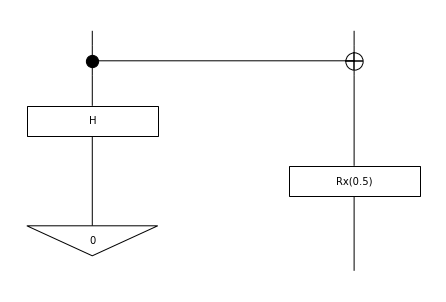

In [33]:
from discopy.quantum.gates import CX, Rx, H, Bra, Id

equality_comparator = (CX >> (H @ Rx(0.5)) >> (Bra(0) @ Id(1)))
equality_comparator.draw()

In [34]:
# from discopy.quantum.gates import CX, Rx, H, Bra, Id

# equality_comparator = (CX >> (H @ Rx(0.5)) >> (Bra(0) @ Id(1)))

# from lambeq import AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz
# from lambeq import TketModel, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset
# import time
# import json

# SEED = 2222
# EPOCHS = 1
# BATCH_SIZE = 30
# ANSATZ_LAYERS=1
# MAXPARAMS = 300

# print(EPOCHS)


# run = wandb.init(
#     # Set the project where this run will be logged
#     project="QNLP_GLUE__from_cyverse_100train_20_dev_with_code_which_gave1",
#     # Track hyperparameters and run metadata
#     config={
#         "learning_rate": 0.01,
#         "epochs": EPOCHS,
#     })


# N = AtomicType.NOUN
# S = AtomicType.SENTENCE
# P = AtomicType.PREPOSITIONAL_PHRASE
# C = AtomicType.CONJUNCTION



# def run_experiment(nlayers=ANSATZ_LAYERS, seed=SEED):
  
#     print("***************newrun***********\n")
#     print(f'RUNNING WITH {nlayers} layers')
#     ansatz = Sim15Ansatz({N: 1, S: 1, P:1,C:1}, n_layers=nlayers, n_single_qubit_params=3)
    
#     #exact location where circuits are being generated
    
#     train_circs = [ansatz(d) >> equality_comparator for d in train_X]
#     test_circs = [ansatz(d) >> equality_comparator for d in test_X]
#     len(train_circs)
#     len(test_circs)
#     #lmbq_model = TketModel.from_diagrams(train_circs)
#     lmbq_model = NumpyModel.from_diagrams(train_circs, use_jit=True)
   

#     trainer = QuantumTrainer(
#         lmbq_model,
#         loss_function=loss,
#         epochs=EPOCHS,
#         optimizer=SPSAOptimizer,
#         optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
#         evaluate_functions=eval_metrics,
#         evaluate_on_train=True,
#         verbose = 'text',
#         seed=seed
#     )

#     train_dataset = Dataset(
#                 train_circs,
#                 train_y,
#                 batch_size=BATCH_SIZE)
    
#     np.random.seed(seed)

#     train_embeddings, test_embeddings, max_w_param_length = generate_initial_parameterisation(train_circs, test_circs, embedding_model, lmbq_model)

#     print('BEGINNING QNLP MODEL TRAINING')
#     try:
#         trainer.fit(train_dataset, logging_step=100,evaluation_step = 1)
#     except Exception as ex:
#         print(f"got error at trainer.fit of QNLP model training")
#         print(ex)

#     train_preds = lmbq_model.get_diagram_output(train_circs)
#     train_loss = loss(train_preds, train_y)
#     train_acc = acc(train_preds, train_y)
#     wandb.log({"train_accuracy": train_acc, "train_loss": train_loss})
#     print(f'TRAIN STATS: {train_loss, train_acc.item()}')

#     try:
#         test_preds = lmbq_model.get_diagram_output(test_circs)
#         test_loss = loss(test_preds, test_y)
#         test_acc = acc(test_preds, test_y)
#         wandb.log({"test_acc": test_acc, "test_loss": test_loss})
#         print(f'Test STATS: {test_loss, test_acc.item()}')
#     except Exception as ex:
#         print("error occured inside test loss. Mostly OOV" )
#         print(ex)

#     print('BEGINNING DNN MODEL TRAINING')
#     NN_model = lmbq_model
#     try:
#         #circuit conversion happens inside this
#         NN_model = generate_OOV_parameterising_model(lmbq_model, train_embeddings, max_w_param_length)
#     except Exception as ex:
#         print(f"got error at generate_OOV_parameterising_model")
#         print(ex)

#     prediction_model = NumpyModel.from_diagrams(test_circs, use_jit=True)

#     trained_wts = trained_params_from_model(lmbq_model, train_embeddings, max_w_param_length)
    
#     print('Evaluating SMART MODEL')
#     smart_loss, smart_acc = evaluate_test_set(prediction_model,
#                                               test_circs,
#                                               test_y,
#                                               trained_wts,
#                                               test_embeddings,
#                                               max_w_param_length,
#                                               OOV_strategy='model',
#                                               OOV_model=NN_model)
#     wandb.log({"smart_acc": smart_acc, "smart_loss": smart_loss})
#     print(f"smart_acc: {smart_acc}, smart_loss: {smart_loss}")
#     print('Evaluating EMBED model')
#     embed_loss, embed_acc = evaluate_test_set(prediction_model,
#                                               test_circs,
#                                               test_y,
#                                               trained_wts,
#                                               test_embeddings,
#                                               max_w_param_length,
#                                               OOV_strategy='embed')

#     print(f"embed_acc: {embed_acc}, embed_loss: {embed_loss}")
#     wandb.log({"embed_acc": embed_acc, "embed_loss": embed_loss})
#     print('Evaluating ZEROS model')
#     zero_loss, zero_acc = evaluate_test_set(prediction_model,
#                                               test_circs,
#                                               test_y,
#                                               trained_wts,
#                                               test_embeddings,
#                                               max_w_param_length,
#                                               OOV_strategy='zeros')
#     print(f"zero_acc: {zero_acc}, zero_loss: {zero_loss}")
#     wandb.log({"zero_acc": zero_acc, "zero_loss": zero_loss})

#     rand_losses = []
#     rand_accs = []
    
#     print('Evaluating RAND MODEL')
#     for _ in range(1000):


#         rl, ra = evaluate_test_set(prediction_model,
#                                    test_circs,
#                                    test_y,
#                                    trained_wts,
#                                    test_embeddings,
#                                    max_w_param_length,
#                                    OOV_strategy='random')

#         rand_losses.append(rl)
#         rand_accs.append(ra)
    
#     res =  {'TRAIN': (train_loss, train_acc),
#             'NN': (smart_loss, smart_acc),
#             'EMBED': (embed_loss, embed_acc),
#             'RAND': (rand_losses, rand_accs),
#             'ZERO': (zero_loss, zero_acc)
#            }

#     print(f'TRAIN: {res["TRAIN"][1]}')
#     print(f'NN: {res["NN"][1]}')
#     print(f'EMBED: {res["EMBED"][1]}')
#     print(f'ZERO: {res["ZERO"][1]}')

#     current_best_dev_accuracy=max(smart_acc, embed_acc ,zero_acc)

#     return res, current_best_dev_accuracy

# import tensorflow as tf


# compr_results = {}

# tf_seeds = [0, 1, 2]
# best_dev_accuracy_overall = 0

# for tf_seed in tf_seeds:
#     tf.random.set_seed(tf_seed)
#     this_seed_results = []
#     for nl in [3,2,1]:
#       try:
#         res, current_best_dev_accuracy=run_experiment(nl, tf_seed)
#         this_seed_results.append(res)
#         best_dev_accuracy_overall = max(best_dev_accuracy_overall, current_best_dev_accuracy)
#         print(f"best_dev_accuracy_overall={best_dev_accuracy_overall}")
#         wandb.log({"best_dev_accuracy_overall": best_dev_accuracy_overall})

#       except Exception as ex:
#         print(ex)
#         continue
#     compr_results[tf_seed] = this_seed_results


In [36]:
from lambeq import AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz
from lambeq import TketModel, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset
import time
import json

SEED = 0
EPOCHS = 1
BATCH_SIZE = 32

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE




def run_experiment(nlayers=1, seed=SEED):
    print(f'RUNNING WITH {nlayers} layers')
    # print(type(train_y))
    # print(train_y.shape)


    ansatz = Sim15Ansatz({N: 1, S: 1, P:1}, n_layers=nlayers, n_single_qubit_params=3)
    train_circs=[]
    test_circs=[]
    train_y_reduced=[]
    error_counter=0
    

    # a= ansatz(train_X[0])
    # print(type(a))
    # a.draw()

          
    
    for diagram,label in tqdm(zip(train_X,train_y)):
        try:
            train_circs.append(ansatz(diagram))
            #todo: add equuality comparator back in:     
            # train_circs = [ansatz(d) >> equality_comparator for d in train_X]
            # test_circs = [ansatz(d) >> equality_comparator for d in test_X]
            train_y_reduced.append(label)
        except Exception as ex:
            error_counter+=1
            continue

    
    for index,d in enumerate(tqdm(test_X,desc="adding test circuits")):
        try:
            test_circs.append(ansatz(d))
        except Exception as ex:
            error_counter+=1
            continue

    print(train_circs[0].draw())

    assert len(train_circs) == len(train_y_reduced)             

    lmbq_model = NumpyModel.from_diagrams(train_circs, use_jit=False)

    trainer = QuantumTrainer(
        lmbq_model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose = 'text',
        seed=seed
    )    

    train_dataset = Dataset(
                train_circs,
                train_y_reduced,
                batch_size=BATCH_SIZE)
    
    np.random.seed(seed)

    train_embeddings, test_embeddings, max_w_param_length = generate_initial_parameterisation(train_circs, test_circs, embedding_model, lmbq_model)

    print('BEGINNING QNLP MODEL TRAINING')
    trainer.fit(train_dataset)
    
    train_preds = lmbq_model.get_diagram_output(train_circs)
    train_loss = loss(train_preds, train_y_reduced)
    train_acc = acc(train_preds, train_y_reduced)
    print(f'TRAIN STATS: {train_loss, train_acc}')

    print('BEGINNING DNN MODEL TRAINING')
    NN_model = generate_OOV_parameterising_model(lmbq_model, train_embeddings, max_w_param_length)

    prediction_model = NumpyModel.from_diagrams(test_circs, use_jit=True)

    trained_wts = trained_params_from_model(lmbq_model, train_embeddings, max_w_param_length)
    
    print('Evaluating SMART MODEL')
    smart_loss, smart_acc = evaluate_test_set(prediction_model,
                                              test_circs,
                                              test_y,
                                              trained_wts,
                                              test_embeddings,
                                              max_w_param_length,
                                              OOV_strategy='model',
                                              OOV_model=NN_model)
    
    print('Evaluating EMBED model')
    embed_loss, embed_acc = evaluate_test_set(prediction_model,
                                              test_circs,
                                              test_y,
                                              trained_wts,
                                              test_embeddings,
                                              max_w_param_length,
                                              OOV_strategy='embed')
    
    print('Evaluating ZEROS model')
    zero_loss, zero_acc = evaluate_test_set(prediction_model,
                                              test_circs,
                                              test_y,
                                              trained_wts,
                                              test_embeddings,
                                              max_w_param_length,
                                              OOV_strategy='zeros')

    rand_losses = []
    rand_accs = []
    
    print('Evaluating RAND MODEL')
    for _ in range(1000):


        rl, ra = evaluate_test_set(prediction_model,
                                   test_circs,
                                   test_y,
                                   trained_wts,
                                   test_embeddings,
                                   max_w_param_length,
                                   OOV_strategy='random')

        rand_losses.append(rl)
        rand_accs.append(ra)
    
    res =  {'TRAIN': (train_loss, train_acc),
            'NN': (smart_loss, smart_acc),
            'EMBED': (embed_loss, embed_acc),
            'RAND': (rand_losses, rand_accs),
            'ZERO': (zero_loss, zero_acc)
           }
    print(f'ZERO: {res["ZERO"]}')
    print(f'EMBED: {res["EMBED"]}')
    print(f'NN: {res["NN"]}')

    return res

# #todo:april 5th 2024
# - assert len


RUNNING WITH 3 layers


64it [00:04, 15.62it/s]
adding test circuits: 100%|██████████| 10/10 [00:00<00:00, 23.11it/s]


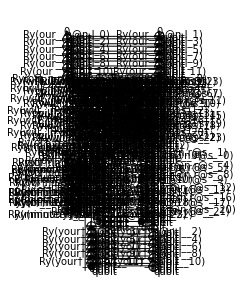

None
593 523 98
OOV word count: 70 / 98
OOV symbol count: 831 / 1248
Max params/word: 54
BEGINNING QNLP MODEL TRAINING


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (32, 2) + inhomogeneous part.

In [37]:
import tensorflow as tf
compr_results = {}

tf_seeds = [0, 1, 2]

for tf_seed in tf_seeds:
    tf.random.set_seed(tf_seed)
    this_seed_results = []
    for nl in [3,2,1]:
        this_seed_results.append(run_experiment(nl, tf_seed))
    compr_results[tf_seed] = this_seed_results